In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from PIL import Image
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Paths
DATA_DIR = Path("/content/drive/MyDrive")
CALIB_DIR = DATA_DIR / "calibration"
GNSS_FILE = DATA_DIR / "gnss.csv"
LIDAR_DIR = DATA_DIR / "lidar"
XBAND_DIR = DATA_DIR / "X_band_radar"
OUTPUT_DIR = DATA_DIR / "synced_output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
# Device
device = torch.device("cpu")  # Force CPU to avoid OOM


In [5]:
# Load MobileNetV2 (lightweight)
mobilenet = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
mobilenet_feat = nn.Sequential(
    *list(mobilenet.features),
    nn.AdaptiveAvgPool2d((1, 1))
).to(device).eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 85.2MB/s]


In [6]:
# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
# Load calibration
def load_matrix(path):
    matrix = []
    if not path.exists():
        print(f"⚠️ Calibration file not found: {path}, using identity.")
        return np.eye(4)
    with open(path, 'r') as f:
        for line in f:
            try:
                row = [float(x) for x in line.strip().split()]
                if len(row) == 4:
                    matrix.append(row)
            except ValueError:
                continue
    matrix_np = np.array(matrix)
    if matrix_np.shape == (2, 4):
        print(f"⚠️ Unexpected calibration matrix shape: {matrix_np.shape}, expanding...")
        matrix_np = np.vstack([matrix_np, [[0, 0, 0, 1], [0, 0, 0, 0]]])
    elif matrix_np.shape == (3, 4):
        matrix_np = np.vstack([matrix_np, [0, 0, 0, 1]])
    if matrix_np.shape != (4, 4):
        print(f"⚠️ Still malformed, using identity.")
        return np.eye(4)
    return matrix_np

T_base2lidar = load_matrix(CALIB_DIR / "Base2lidar.txt")
T_base2xband = load_matrix(CALIB_DIR / "Base2xband.txt")

⚠️ Unexpected calibration matrix shape: (2, 4), expanding...
⚠️ Unexpected calibration matrix shape: (2, 4), expanding...


In [8]:
# Index files
def index_files_by_timestamp(folder, ext):
    if not folder.exists():
        return {}
    return {int(f.stem): f for f in folder.glob(f"*.{ext}") if f.stem.isdigit()}

lidar_ts = index_files_by_timestamp(LIDAR_DIR, "bin")
xband_ts = index_files_by_timestamp(XBAND_DIR, "png")
print(f"🔎 Found {len(lidar_ts)} LiDAR files and {len(xband_ts)} X-Band files")

🔎 Found 30 LiDAR files and 30 X-Band files


In [9]:
# Load LiDAR
def load_lidar(file):
    pts = np.fromfile(file, dtype=np.float32).reshape(-1, 4)[:, :3]
    pts_h = np.hstack([pts, np.ones((pts.shape[0], 1))])
    pts_trans = (T_base2lidar @ pts_h.T).T[:, :3]
    return pts_trans

In [10]:
# Feature extraction
def extract_lidar_features(pts):
    try:
        mean_xyz = np.mean(pts, axis=0)
        std_xyz = np.std(pts, axis=0)
        max_xyz = np.max(pts, axis=0)
        min_xyz = np.min(pts, axis=0)
        return np.concatenate([mean_xyz, std_xyz, max_xyz, min_xyz])
    except Exception as e:
        print(f"⚠️ LiDAR feature error: {e}")
        return np.zeros(12)

def extract_image_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = mobilenet_feat(img).view(-1).cpu().numpy()
        return feat
    except Exception as e:
        print(f"⚠️ Image feature error: {e}")
        return np.zeros(1280)


In [11]:
# GNSS
if GNSS_FILE.exists():
    gnss_df = pd.read_csv(GNSS_FILE)
    gnss_df['timestamp'] = pd.to_numeric(gnss_df['timestamp'], errors='coerce')
    gnss_df = gnss_df.dropna(subset=['timestamp'])

    def get_gnss_for_ts(ts):
        row = gnss_df.iloc[(gnss_df['timestamp'] - ts).abs().argsort()[:1]]
        return row.to_dict('records')[0] if not row.empty else None
else:
    print(f"⚠️ GNSS file not found: {GNSS_FILE}")
    def get_gnss_for_ts(ts): return None

In [12]:
# Synchronization
feature_pairs = []
for ts_lidar, lidar_file in lidar_ts.items():
    print(f"📦 Processing LiDAR timestamp: {ts_lidar}")
    lidar_data = load_lidar(lidar_file)
    lidar_feat = extract_lidar_features(lidar_data)
    for ts_x, x_file in xband_ts.items():
        print(f"🖼️  Comparing with X-Band timestamp: {ts_x}")
        x_feat = extract_image_features(x_file)
        min_dim = min(len(lidar_feat), len(x_feat))
        sim = cosine_similarity([lidar_feat[:min_dim]], [x_feat[:min_dim]])[0][0]
        feature_pairs.append((sim, ts_lidar, ts_x))
        print(f"✅ Similarity score: {sim:.4f}")

📦 Processing LiDAR timestamp: 1724625922215306315
🖼️  Comparing with X-Band timestamp: 1724625906223010255
✅ Similarity score: 0.0215
🖼️  Comparing with X-Band timestamp: 1724625915223804768
✅ Similarity score: 0.0669
🖼️  Comparing with X-Band timestamp: 1724625904222401724
✅ Similarity score: 0.0304
🖼️  Comparing with X-Band timestamp: 1724625918224243534
✅ Similarity score: 0.0484
🖼️  Comparing with X-Band timestamp: 1724625916224401283
✅ Similarity score: 0.0471
🖼️  Comparing with X-Band timestamp: 1724625908223305198
✅ Similarity score: 0.0303
🖼️  Comparing with X-Band timestamp: 1724625899223239997
✅ Similarity score: 0.0270
🖼️  Comparing with X-Band timestamp: 1724625912223208449
✅ Similarity score: 0.0569
🖼️  Comparing with X-Band timestamp: 1724625903222734625
✅ Similarity score: 0.0333
🖼️  Comparing with X-Band timestamp: 1724625895223246991
✅ Similarity score: 0.0188
🖼️  Comparing with X-Band timestamp: 1724625897222549275
✅ Similarity score: 0.0260
🖼️  Comparing with X-Band 

In [13]:
# Sort and save
feature_pairs.sort(reverse=True)
synced_data, summary, saved_pairs = [], [], set()
for i, (sim, ts_lidar, ts_x) in enumerate(feature_pairs[:30]):
    if (ts_lidar, ts_x) in saved_pairs:
        continue
    try:
        lidar_data = load_lidar(lidar_ts[ts_lidar])
        xband_img = Image.open(xband_ts[ts_x]).convert("RGB")
        gnss_info = get_gnss_for_ts(ts_lidar)

        np.save(OUTPUT_DIR / f"lidar_{i}.npy", lidar_data)
        xband_img.save(OUTPUT_DIR / f"xband_{i}.png")
        with open(OUTPUT_DIR / f"gnss_{i}.json", 'w') as f:
            json.dump(gnss_info, f)

        synced_data.append({
            "timestamp": ts_lidar,
            "lidar": lidar_data,
            "xband": np.array(xband_img),
            "gnss": gnss_info,
            "similarity_score": sim
        })

        summary.append({
            "index": i,
            "timestamp": ts_lidar,
            "lidar_shape": lidar_data.shape,
            "xband_shape": xband_img.size,
            "similarity_score": sim,
            "gnss_lat": gnss_info.get("latitude") if gnss_info else None,
            "gnss_lon": gnss_info.get("longitude") if gnss_info else None
        })

        saved_pairs.add((ts_lidar, ts_x))
    except Exception as e:
        print(f"⚠️ Error saving frame {i}: {e}")

In [14]:
# Save summary
if summary:
    summary_df = pd.DataFrame(summary)

    # Fix NaNs in object-type columns:
    summary_df['lidar_shape'] = summary_df['lidar_shape'].astype(str)
    summary_df['xband_shape'] = summary_df['xband_shape'].astype(str)
    summary_df['gnss_lat'] = summary_df['gnss_lat'].fillna("-")
    summary_df['gnss_lon'] = summary_df['gnss_lon'].fillna("-")

    # Save cleaned summary
    summary_df.to_csv(OUTPUT_DIR / "synced_summary.csv", index=False)

    print(f"\n✅ Synchronized {len(synced_data)} frames saved in: {OUTPUT_DIR}")
    print("\n📊 Summary statistics:")
    print(summary_df.describe(include='all').fillna("-"))  # Optional final NaN handling



✅ Synchronized 30 frames saved in: /content/drive/MyDrive/synced_output

📊 Summary statistics:
           index              timestamp lidar_shape   xband_shape  \
count       30.0                   30.0          30            30   
unique         -                      -          28             1   
top            -                      -  (31922, 3)  (2048, 2048)   
freq           -                      -           2            30   
mean        14.5  1724625908715105792.0           -             -   
std     8.803408       8803698146.78393           -             -   
min          0.0  1724625894214986752.0           -             -   
25%         7.25  1724625901464440832.0           -             -   
50%         14.5  1724625908715315712.0           -             -   
75%        21.75  1724625915965724416.0           -             -   
max         29.0  1724625923214700288.0           -             -   

       similarity_score gnss_lat    gnss_lon  
count              30.0     


📸 First synchronized sample:
             timestamp lidar_shape      xband_shape  similarity_score  \
0  1724625894214986733  (32061, 3)  (2048, 2048, 3)          0.094162   

                                           gnss_info  
0  {'rosbag_file': 'S_HONESTMISTAKE_SEAD-CM-2200-...  


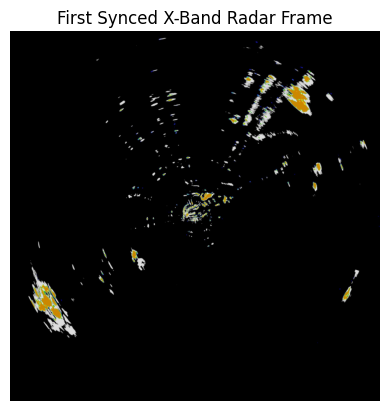

In [15]:
# Visualization
if synced_data:
    frame = synced_data[0]
    print("\n📸 First synchronized sample:")
    print(pd.DataFrame([{
        "timestamp": frame["timestamp"],
        "lidar_shape": frame["lidar"].shape,
        "xband_shape": frame["xband"].shape,
        "similarity_score": frame["similarity_score"],
        "gnss_info": frame["gnss"]
    }]))
    plt.imshow(frame["xband"])
    plt.title("First Synced X-Band Radar Frame")
    plt.axis("off")
    plt.show()